# Ресерч

В рамках данного ресерча будет:

1) Проанализировано влияние новостей

    1.1) Построены графики

    1.2) Предобработаны данные

    1.3) Размечены данные (потом это пойдет в Marker.py). На разметке будет обучена модель ранжирования сентимента новостей. Данные будут размечены при помощи LLM (CoT + Few-shot) и провалидированы вручную

    1.4) Удалены выбросы

    1.5) Выполнена кластеризация

    1.6) Завершена предобработка

2) Обучена модель (Семейство моделей на разных эмбеддингах / архитектурах)

3) Анализ  Feature importance

4) Подготовка дообучения модели (Потом пойдет в класс Model)

## Установка необходимых библиотек

Для первичной обработки данных

In [4]:
! pip install pandas numpy seaborn matplotlib pyarrow

  Using cached pyarrow-19.0.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.1-cp312-cp312-manylinux_2_28_x86_64.whl (42.1 MB)


## Импортирование библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Первичный анализ входных данных

Откроем файлы

In [8]:
moex_data = pd.read_parquet('../data/moex.parquet')
news_data = pd.read_parquet('../data/news.parquet')
webnews_data = pd.read_parquet('../data/webnews.parquet')
webnews_data['sphere'] = webnews_data['type']
webnews_data.drop(columns=['type'], inplace=True)

Посмотрим на их структуру

In [9]:
moex_data.head()

,company,open,close,begin,end
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59


In [10]:
news_data.head()

,title,datetime,article_text,sphere,source
0,"**Вы знали, что на вашем СНИЛСе хранятся деньги?",2025-02-21T10:11,"**Вы знали, что на вашем СНИЛСе хранятся деньг...",Энергетика,Копейка рубль бережёт
1,🤑Ещё 13 российских банков отключат от SWIFT в ...,2025-02-21T08:21,🤑Ещё 13 российских банков отключат от SWIFT в ...,Финансы,Копейка рубль бережёт
2,🤑Страны G7 намерены отказаться от идеи ужесточ...,2025-02-21T04:28,🤑Страны G7 намерены отказаться от идеи ужесточ...,Энергетика,Копейка рубль бережёт
3,🤑«АвтоВАЗ» опроверг какие-либо контакты с комп...,2025-02-20T16:03,🤑«АвтоВАЗ» опроверг какие-либо контакты с комп...,Энергетика,Копейка рубль бережёт
4,"🤑Официальный курс доллара — ₽88,5.",2025-02-20T15:11,"🤑Официальный курс доллара — ₽88,5. Центробанк ...",Финансы,Копейка рубль бережёт


In [11]:
webnews_data.head()

,title,datetime,article_text,source,sphere
0,ЦБ РФ на заседании в марте может рассмотреть и...,2025-03-01T13:39,Москва. 1 марта. INTERFAX.RU - ЦБ РФ на засед...,Интерфакс,Финансы
1,ЦБ сможет учитывать движения на рынках на фоне...,2025-03-01T12:33,Москва. 1 марта. INTERFAX.RU - Наблюдающиеся ...,Интерфакс,Энергетика
2,Банк России по-прежнему жестко настроен на воз...,2025-03-01T11:57,Москва. 1 марта. INTERFAX.RU - Банк России по...,Интерфакс,Энергетика
3,ЦБ РФ сможет полностью оценить тенденции в кре...,2025-03-01T11:49,Москва. 1 марта. INTERFAX.RU - Банк России см...,Интерфакс,Финансы
4,Пошлина на экспорт подсолнечного масла из РФ в...,2025-03-01T00:14,Москва. 1 марта. INTERFAX.RU - Пошлина на экс...,Интерфакс,Энергетика


Посмотрим количество записей для каждой из компаний

In [12]:
moex_data.groupby('company').count()

,open,close,begin,end
company,,,,
GAZP,8314,8314,8314,8314
LKOH,8314,8314,8314,8314
ROSN,8314,8314,8314,8314
SBER,8314,8314,8314,8314
T,8029,8029,8029,8029
VTBR,8254,8254,8254,8254


Выполним аналогичную операцию со сферами

In [13]:
news_data.groupby('sphere').count()

,title,datetime,article_text,source
sphere,,,,
Финансы,3268,3268,3268,3268
Финансы/Энергетика,338,338,338,338
Энергетика,3745,3745,3745,3745


In [14]:
webnews_data.groupby('sphere').count()

,title,datetime,article_text,source
sphere,,,,
Финансы,2743,2743,2743,2743
Финансы/Энергетика,379,379,379,379
Энергетика,2984,2984,2984,2984


Посмотрим начало и конец периодов для записей данных

In [15]:
moex_data['begin'] = pd.to_datetime(moex_data['begin'])
moex_data['end'] = pd.to_datetime(moex_data['end'])

print(min(moex_data['begin']))
print(max(moex_data['end']))


2023-01-03 09:00:00
2025-02-28 20:34:02


In [16]:
news_data['datetime'] = pd.to_datetime(news_data['datetime'])
print(min(news_data['datetime']))
print(max(news_data['datetime']))

2022-09-01 07:10:00
2025-02-21 10:59:00


In [18]:
webnews_data['datetime'] = pd.to_datetime(webnews_data['datetime'])
print(min(webnews_data['datetime']))
print(max(webnews_data['datetime']))

2024-10-31 13:31:00
2025-03-01 13:39:00


Заметим, что у нас маленький период данных по webnews, так что их мы никак будем ограничивать по остальным параметрам

Оставим только данные в один и тот же период

In [21]:
min_news_datetime = min(news_data['datetime'])
max_news_datetime = max(news_data['datetime'])
min_moex_begin = min(moex_data['begin'])
max_moex_end = max(moex_data['end'])

lower_bound = max(min_news_datetime, min_moex_begin)
upper_bound = min(max_news_datetime, max_moex_end)

news_data = news_data[(news_data['datetime'] >= lower_bound) & (news_data['datetime'] <= upper_bound)]

moex_data = moex_data[(moex_data['begin'] >= lower_bound) & (moex_data['end'] <= upper_bound)]
webnews_data = webnews_data[(webnews_data['datetime'] >= lower_bound) & (webnews_data['datetime'] <= upper_bound)]

In [22]:
print('moex data')
print(min(moex_data['begin']))
print(max(moex_data['end']))

print('news_data')
print(min(news_data['datetime']))
print(max(news_data['datetime']))

print('webnews_data')
print(min(webnews_data['datetime']))
print(max(webnews_data['datetime']))

moex data
2023-01-03 10:00:00
2025-02-21 09:59:59
news_data
2023-01-03 09:16:00
2025-02-21 08:46:00
webnews_data
2024-10-31 13:31:00
2025-02-21 09:26:00


Визуализируем цены акций

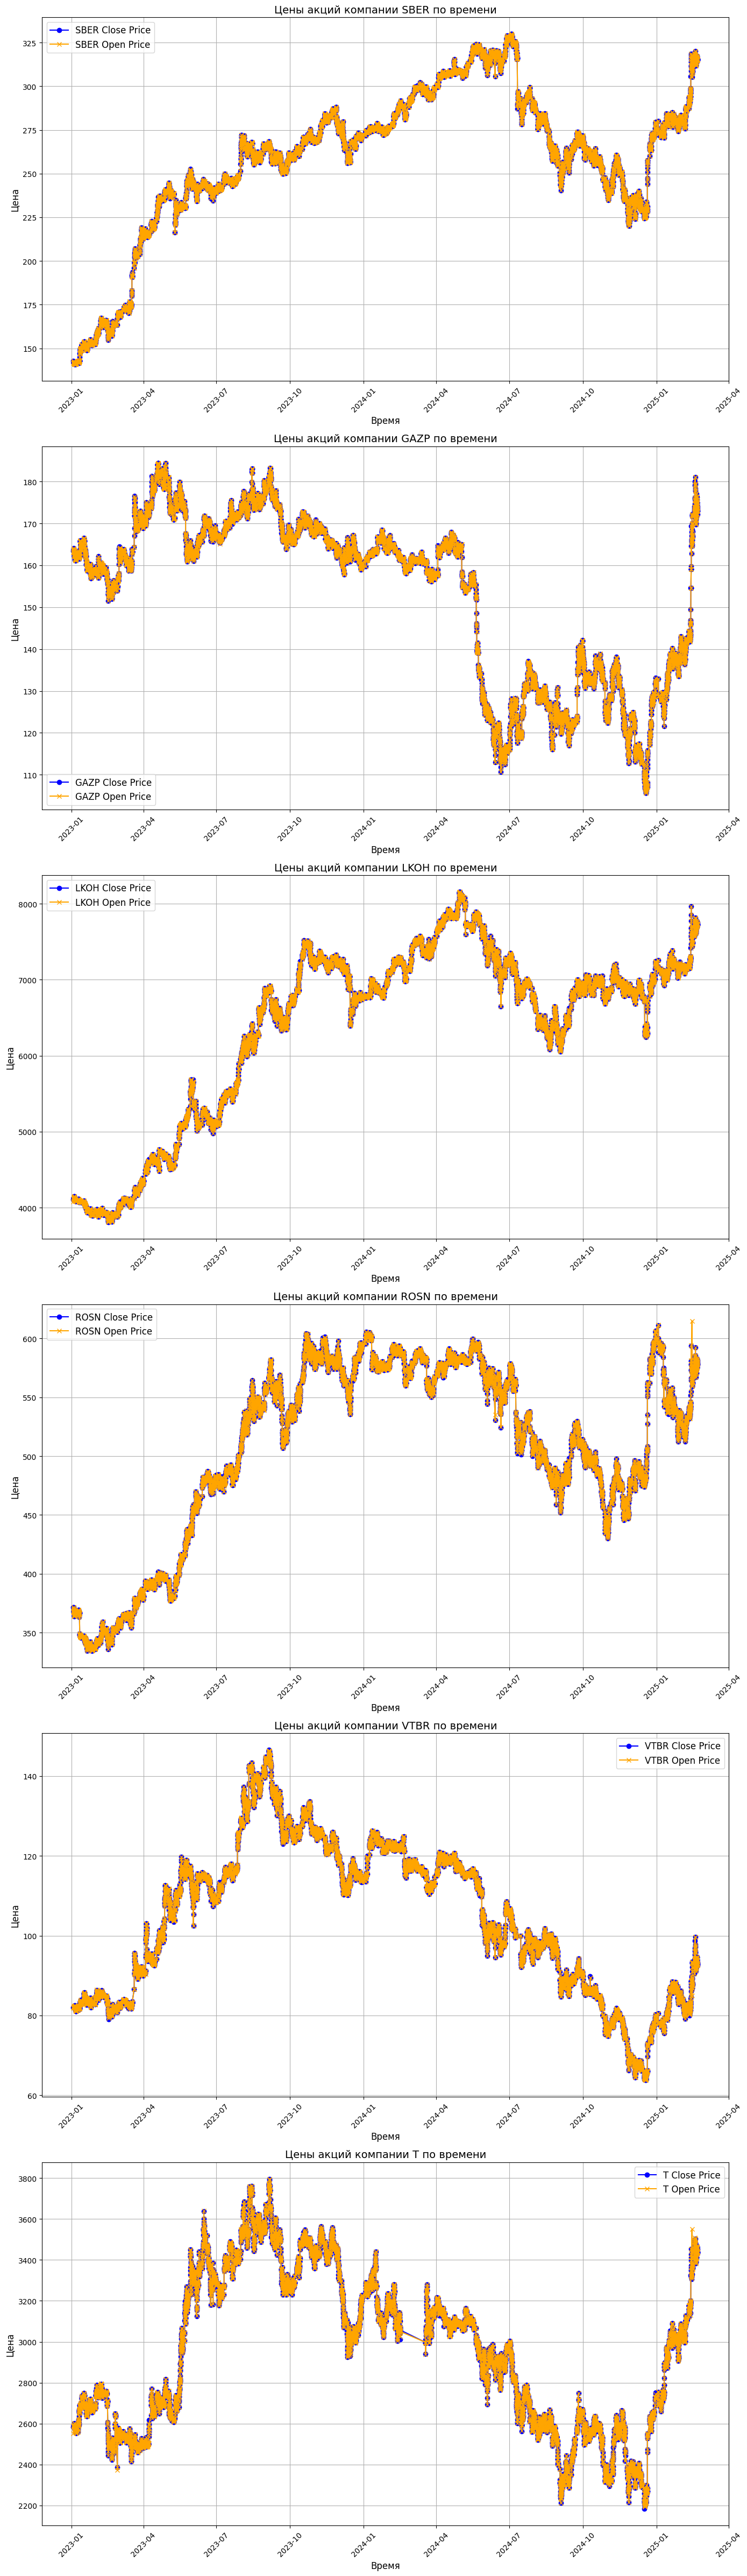

In [23]:
companies = moex_data['company'].unique()

plt.figure(figsize=(14, 8 * len(companies))) 
for i, company in enumerate(companies, 1):
    plt.subplot(len(companies), 1, i)  
    company_data = moex_data[moex_data['company'] == company]
    plt.plot(company_data['begin'], company_data['close'], label=f'{company} Close Price', color='blue', marker='o')
    plt.plot(company_data['begin'], company_data['open'], label=f'{company} Open Price', color='orange', marker='x')
    plt.title(f'Цены акций компании {company} по времени', fontsize=14)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Цена', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

Визуализируем количество новостей за этот период

Дата с максимальным количеством новостей для сферы 'Финансы': 2024-11-21
Дата с максимальным количеством новостей для сферы 'Энергетика': 2024-03-06
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2024-09-04


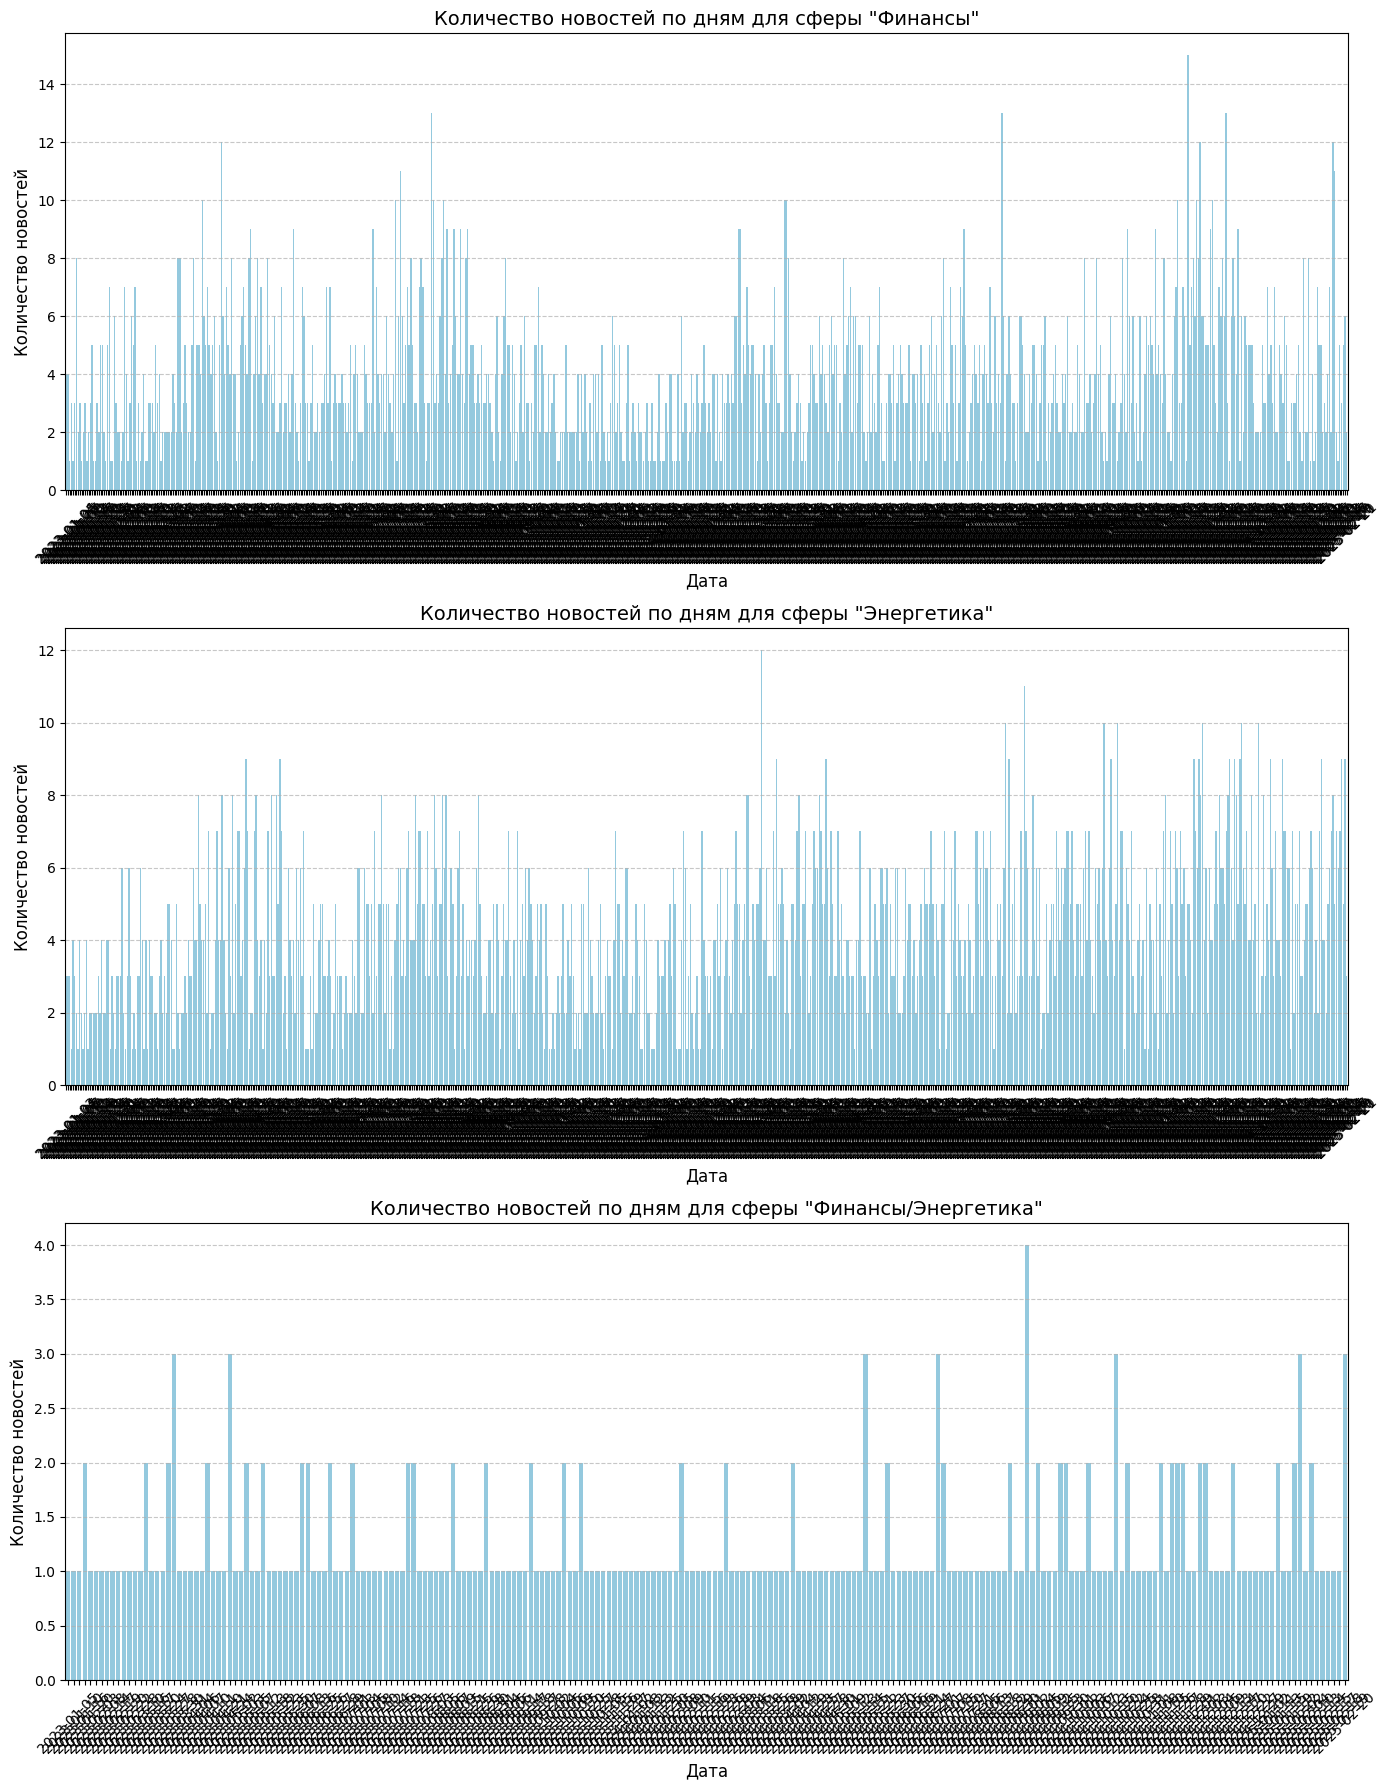

In [24]:
news_data['date'] = news_data['datetime'].dt.date 
spheres = news_data['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = news_data[news_data['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

Выполним аналогичную операцию с webnews

Дата с максимальным количеством новостей для сферы 'Финансы': 2024-11-29
Дата с максимальным количеством новостей для сферы 'Энергетика': 2025-01-15
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2025-02-14


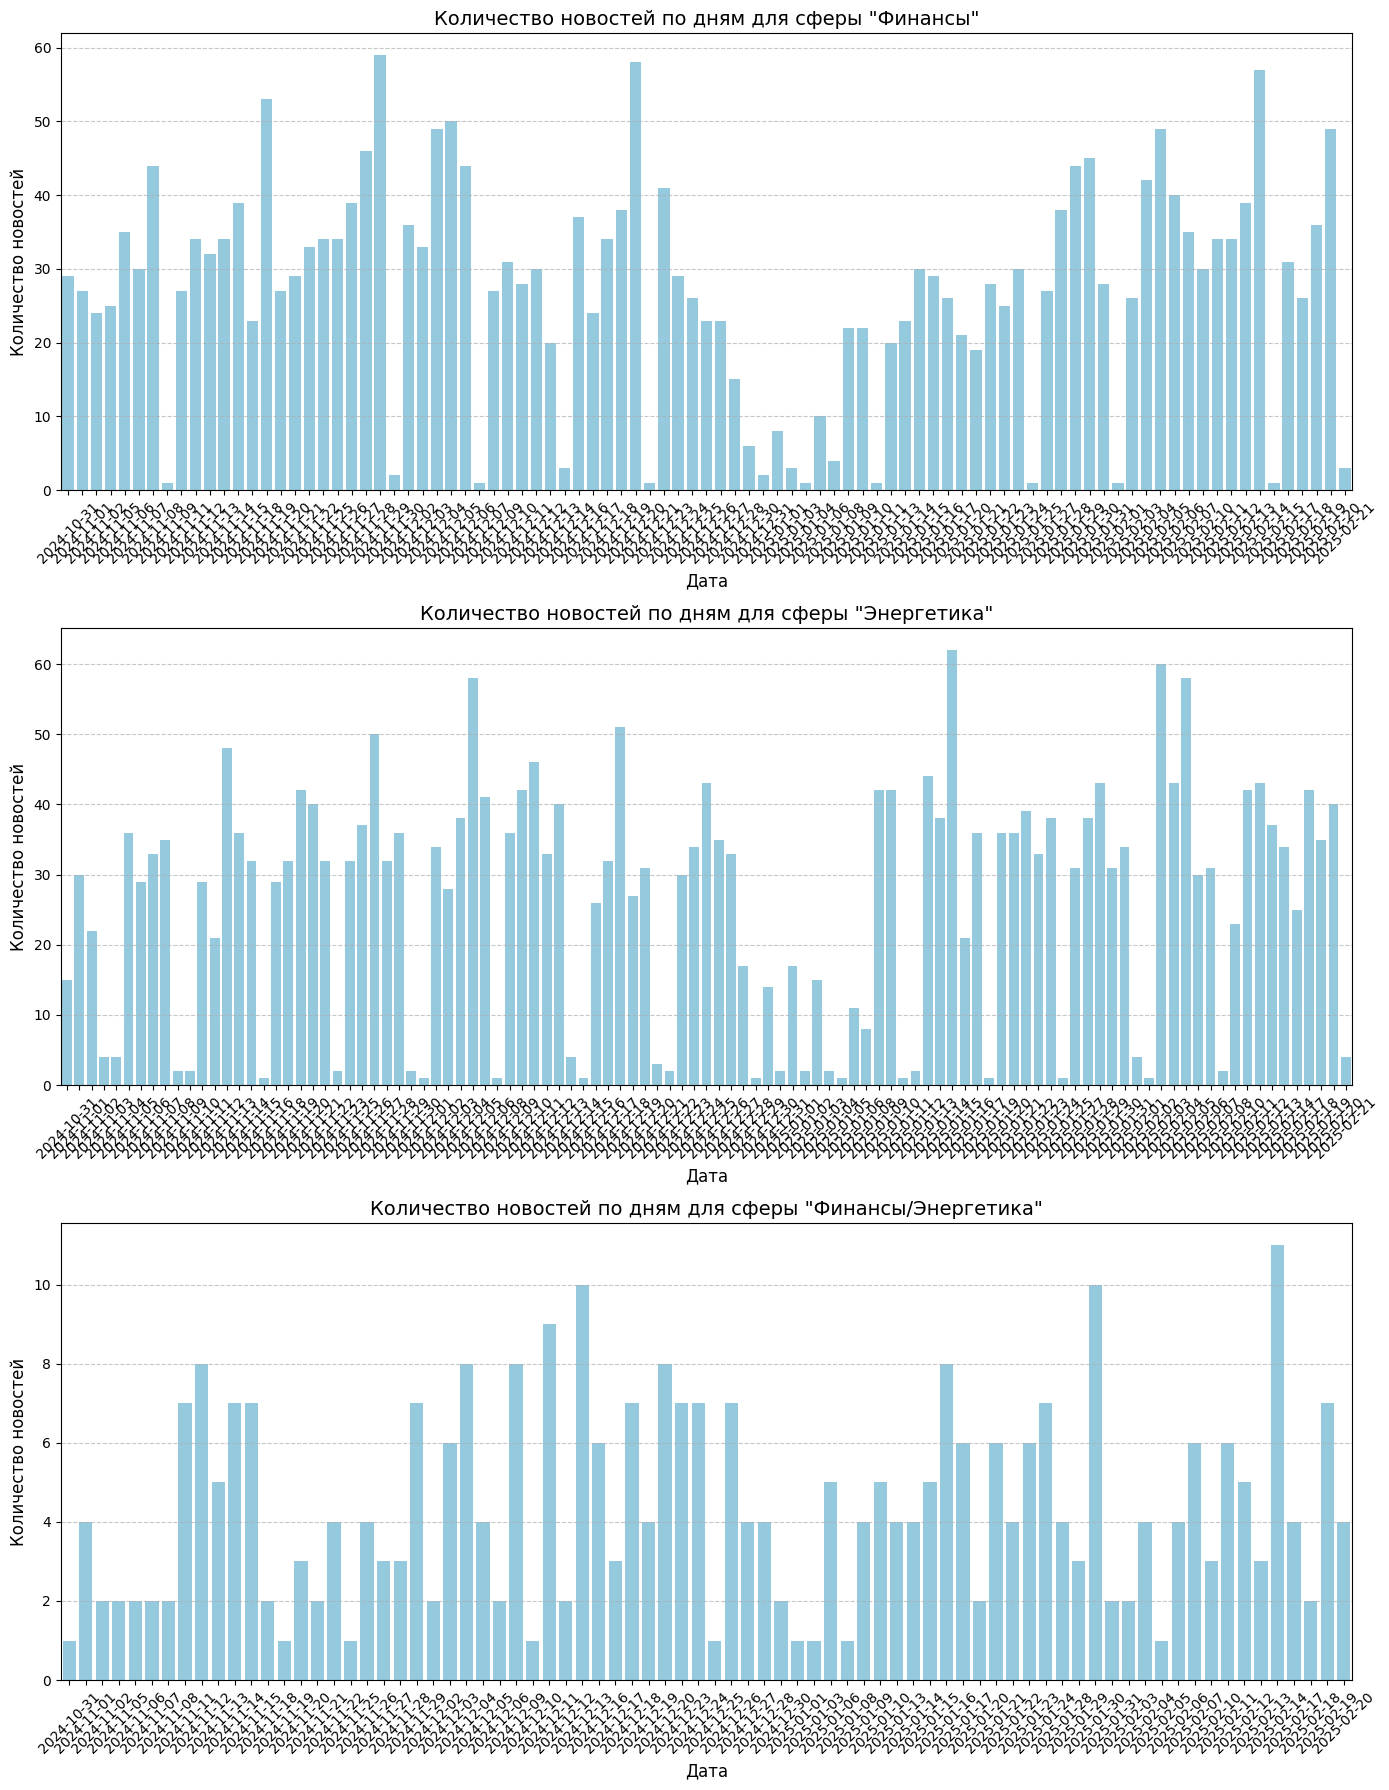

In [36]:
webnews_data['date'] = webnews_data['datetime'].dt.date 
spheres = webnews_data['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = webnews_data[webnews_data['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

Теперь объединим новости с флагом 

1 - для новостей из интернета

0 - для новостей из telegram

In [30]:
webnews_data['web'] = [1] * len(webnews_data)
news_data['web'] = [0] * len(news_data)
news = pd.concat([webnews_data, news_data], ignore_index=True)

In [33]:
news.head()

,title,datetime,article_text,source,sphere,date,web
0,Суд удовлетворил иск Промсвязьбанка к бывшему ...,2025-02-21 09:26:00,Москва. 21 февраля. INTERFAX.RU - Арбитражный...,Интерфакс,Финансы,2025-02-21,1
1,Минсельхоз России не фиксирует существенного п...,2025-02-21 09:20:00,Москва. 21 февраля. INTERFAX.RU - Ситуация на...,Интерфакс,Энергетика,2025-02-21,1
2,Минсельхоз России не фиксирует существенного п...,2025-02-21 09:20:00,Москва. 21 февраля. INTERFAX.RU - Ситуация на...,Интерфакс,Энергетика,2025-02-21,1
3,Booking увеличил чистую прибыль в IV квартале ...,2025-02-21 09:17:00,Москва. 21 февраля. INTERFAX.RU - Американска...,Интерфакс,Финансы,2025-02-21,1
4,"УК аэропортов группы ""Русал"" увеличила уставны...",2025-02-21 08:48:00,"Москва. 21 февраля. INTERFAX.RU - ООО ""Сибирс...",Интерфакс,Финансы,2025-02-21,1


Построим аналогичный график для news

Дата с максимальным количеством новостей для сферы 'Финансы': 2025-02-14
Дата с максимальным количеством новостей для сферы 'Энергетика': 2025-01-15
Дата с максимальным количеством новостей для сферы 'Финансы/Энергетика': 2025-02-14


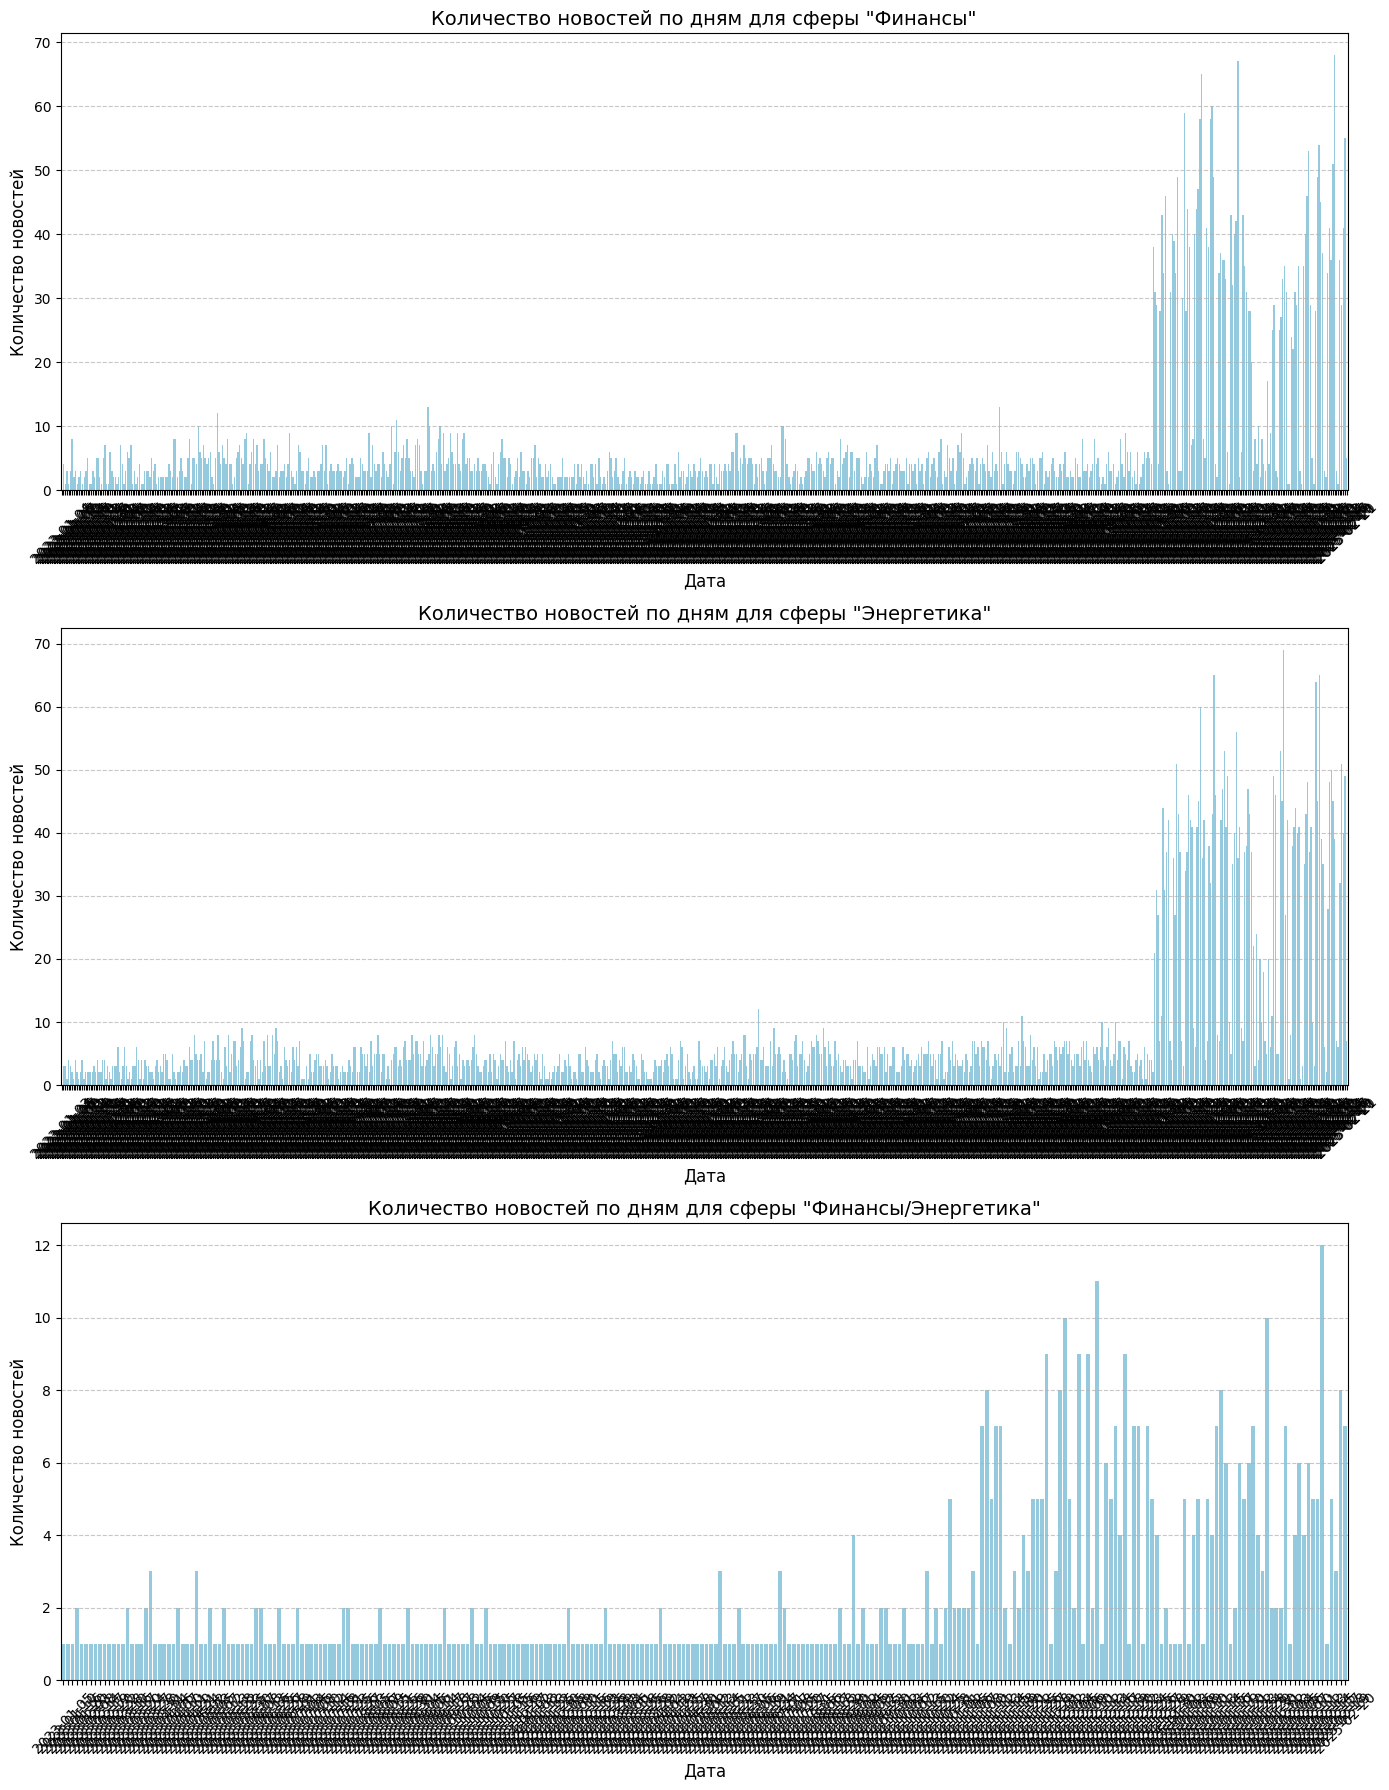

In [37]:
news['date'] = news['datetime'].dt.date 
spheres = news['sphere'].unique()

plt.figure(figsize=(14, 6 * len(spheres))) 

for i, sphere in enumerate(spheres, 1):
    plt.subplot(len(spheres), 1, i) 
    sphere_data = news[news['sphere'] == sphere]
    
    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Выводим даты для максимума по новостям

    grouped_data = sphere_data.groupby('date').size().reset_index(name='count')

    # Находим дату с максимальным количеством новостей
    max_date = grouped_data.loc[grouped_data['count'].idxmax(), 'date']

    print(f"Дата с максимальным количеством новостей для сферы '{sphere}': {max_date}")

    
    sns.barplot(x='date', y='count', data=grouped_data, color='skyblue')
    plt.title(f'Количество новостей по дням для сферы "{sphere}"', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество новостей', fontsize=12)
    plt.xticks(rotation=45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()